In [4]:
import cv2
import numpy as np
from ball_tracking import Tracker
from matplotlib import pyplot as plt
import pandas as pd

In [5]:
cap = cv2.VideoCapture('./calibrated1.mp4')
ret, current_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read video")

corners = {"TL" : [875, 1250], "TR" : [3050, 1250], "BR" : [3700, 1720], "BL": [250, 1720]}

tracker = Tracker(focal_length_px=2880, confidence_threshold=0.8, image_size=current_frame.shape, table_points=corners)

In [6]:
# no_ball = cv2.imread("no_ball1.png")
# front_ball = cv2.imread("front_ball1.png")
# back_ball = cv2.imread("back_ball1.png")
# plt.imshow(no_ball)

# tracker.corner_calibration(no_ball, front_ball, back_ball)
# print(tracker.corner_distances)
# tracker.set_distances()

In [ ]:
tracker.set_table_points({"TL" : [240, 390], "TR" : [1000, 400], "BR" : [1220, 570], "TR" : [15, 570]})

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
previous_frame = current_frame.copy()

h, w = current_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("diff_video.mp4", fourcc, 10, (w, h))

i = 0
heights = []
scores = []
while True:
    ret, current_frame = cap.read()
    i += 1
    print("processing frame", i, end="\r")
    if i < 0:
        continue
    if not ret or i >= 1000:
        break

    detection, score = tracker.track(current_frame)
    
    if not detection is None and score > 0.8:
        heights.append(detection[1][0])
        scores.append(score)
    
    circled_frame = tracker.write_data(current_frame, detection, score)
    video.write(circled_frame)

    previous_frame = current_frame.copy()

video.release()
cap.release()

/home/damian/pingpong/ball_tracking.py:191: RuntimeWarning: divide by zero encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2
/home/damian/pingpong/ball_tracking.py:191: RuntimeWarning: invalid value encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2


AttributeError: 'Tracker' object has no attribute 'H'

(154,) (154,)


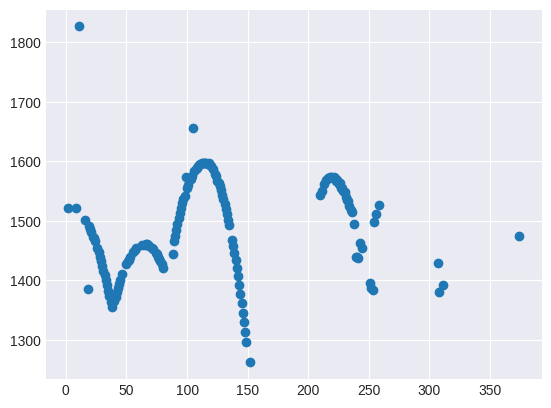

In [ ]:
position_data = pd.DataFrame({"positions_x" : np.array(tracker.recorded_positions2d)[:, 0], "positions_y" : np.array(tracker.recorded_positions2d)[:, 1]})
print(np.array(tracker.frame_numbers).shape, np.array([pos[1] for pos in tracker.recorded_positions]).shape)
plt.scatter(tracker.frame_numbers, position_data["positions_y"])

<Axes: >

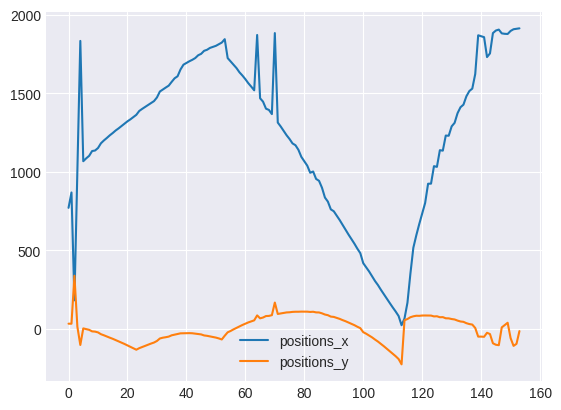

In [ ]:
from scipy.ndimage import median_filter
position_data['positions_y'] = position_data["positions_y"].map(lambda x: median_filter(x, 9)) - np.mean(position_data["positions_y"])
position_data.plot()

<Axes: >

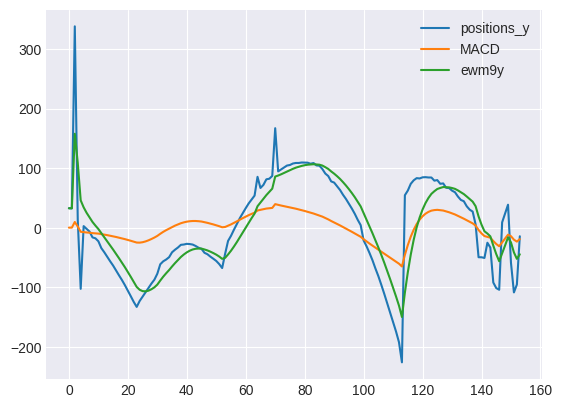

In [ ]:
position_data["ewm9y"] = position_data["positions_y"].ewm(span=9).mean()
position_data["ewm12y"] = position_data["positions_y"].ewm(span=12).mean()
position_data["ewm26y"] = position_data["positions_y"].ewm(span=26).mean()
position_data['MACD'] = position_data["ewm12y"] - position_data["ewm26y"]
position_data[["positions_y", "MACD", "ewm9y"]].plot()

In [ ]:
position_data["delta_y"] = np.concatenate(([np.nan], np.diff(position_data["positions_y"], n=1)))
position_data["delta_y"] = position_data["delta_y"].map(lambda x: median_filter(x, 3))
position_data["delta_y"] = position_data["delta_y"].rolling(window=3).mean()

<Axes: >

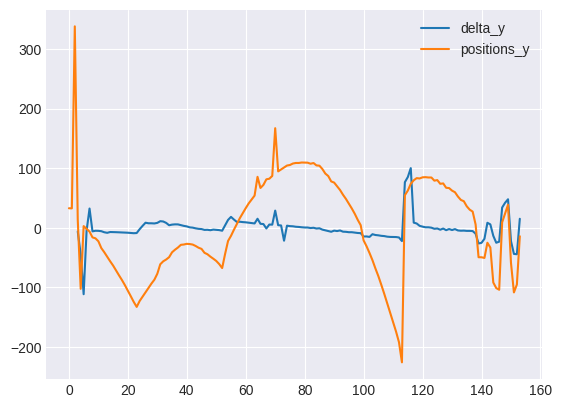

In [ ]:
position_data[["delta_y", "positions_y"]].plot()

In [ ]:
def is_bounce(data):
    positive = np.greater(data, 0)
    middle = len(data) // 2
    return np.sum(positive[:middle]) < middle * 0.2 and np.sum(positive[middle:]) > middle * 0.8

bounces = position_data["delta_y"].rolling(window=6).apply(is_bounce)

In [ ]:
print(np.where(bounces))

(array([  0,   1,   2,   3,   4,   5,   6,   7,  27,  55, 116, 149]),)


In [ ]:
type(position_data["delta_y"])

pandas.core.series.Series

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def find_robust_peaks(data, smooth_window_size=11, prominence=0.5, distance=50, peak_type='min'):
    """
    Finds robust local minima (valleys), maxima (peaks), or both in a noisy 1D dataset.

    This function is designed to find significant "bounces" or "valleys"
    while ignoring minor fluctuations from noise.

    It works in two stages:
    1. Smooths the data using a simple moving average (SMA).
    2. Finds peaks in the *inverted* (for minima) or *regular* (for maxima)
       smoothed data, using 'prominence' to filter out insignificant peaks.

    Args:
        data (np.array): The 1D array of height values.
        smooth_window_size (int): The number of points to include in the moving average.
                                 Must be an odd number.
        prominence (float): The required prominence of a peak/minimum. This is the
                            most important parameter for filtering noise. It
                            measures how much the peak stands out from its
                            surrounding "shoulders".
        distance (int): The minimum number of data points between adjacent peaks/minima.
        peak_type (str): What to detect. Options are:
                         - 'min': Find local minima (default).
                         - 'max': Find local maxima.
                         - 'both': Find both minima and maxima.

    Returns:
        tuple: (indices, smoothed_data, properties)
            - indices (np.array or dict):
                - If 'min' or 'max', returns an array of detected indices.
                - If 'both', returns a dict: {'minima': [...], 'maxima': [...]}
            - smoothed_data (np.array): The smoothed version of the original data.
            - properties (dict):
                - If 'min' or 'max', returns the properties dict from `find_peaks`.
                - If 'both', returns a dict: {'minima': {...}, 'maxima': {...}}
    """
    if smooth_window_size % 2 == 0:
        print("Warning: smooth_window_size should be odd. Incrementing by 1.")
        smooth_window_size += 1
        
    if len(data) < smooth_window_size:
        print("Error: Data is shorter than the smoothing window.")
        return np.array([]), data

    # 1. Smooth the data using a simple moving average (convolution)
    # 'mode=same' ensures the output array is the same size as the input.
    # 'valid' would be more accurate at the cost of trimming the edges.
    window = np.ones(smooth_window_size) / smooth_window_size
    smoothed_data = np.convolve(data, window, mode='same')
    
    # Handle edge effects from convolution ('same' mode)
    # We replace the less-accurate edges with the original data
    # or a clipped version of the smoothed data. For simplicity here,
    # we'll just use the convolved data, but be aware edges are less accurate.
    edge_width = (smooth_window_size - 1) // 2
    smoothed_data[:edge_width] = smoothed_data[edge_width]
    smoothed_data[-edge_width:] = smoothed_data[-edge_width-1]

    # 2. Find minima and/or maxima
    
    minima_indices, min_properties = np.array([]), {}
    maxima_indices, max_properties = np.array([]), {}

    # Find minima by finding peaks in the *inverted* data
    if peak_type in ('min', 'both'):
        inverted_data = -smoothed_data
        minima_indices, min_properties = find_peaks(
            inverted_data, 
            prominence=prominence, 
            distance=distance
        )
    
    # Find maxima by finding peaks in the *regular* data
    if peak_type in ('max', 'both'):
        maxima_indices, max_properties = find_peaks(
            smoothed_data, 
            prominence=prominence, 
            distance=distance
        )
    
    # Return based on requested type
    if peak_type == 'min':
        return minima_indices, smoothed_data, min_properties
    elif peak_type == 'max':
        return maxima_indices, smoothed_data, max_properties
    elif peak_type == 'both':
        return (
            {'minima': minima_indices, 'maxima': maxima_indices}, 
            smoothed_data, 
            {'minima': min_properties, 'maxima': max_properties}
        )
    else:
        print(f"Warning: Unknown peak_type '{peak_type}'. Defaulting to 'min'.")
        # Recalculate for min if only 'max' was done
        if not minima_indices.any() and peak_type not in ('min', 'both'):
             inverted_data = -smoothed_data
             minima_indices, min_properties = find_peaks(
                inverted_data, prominence=prominence, distance=distance
             )
        return minima_indices, smoothed_data, min_properties

Detected 3 robust minima at indices: [ 10  64 110]


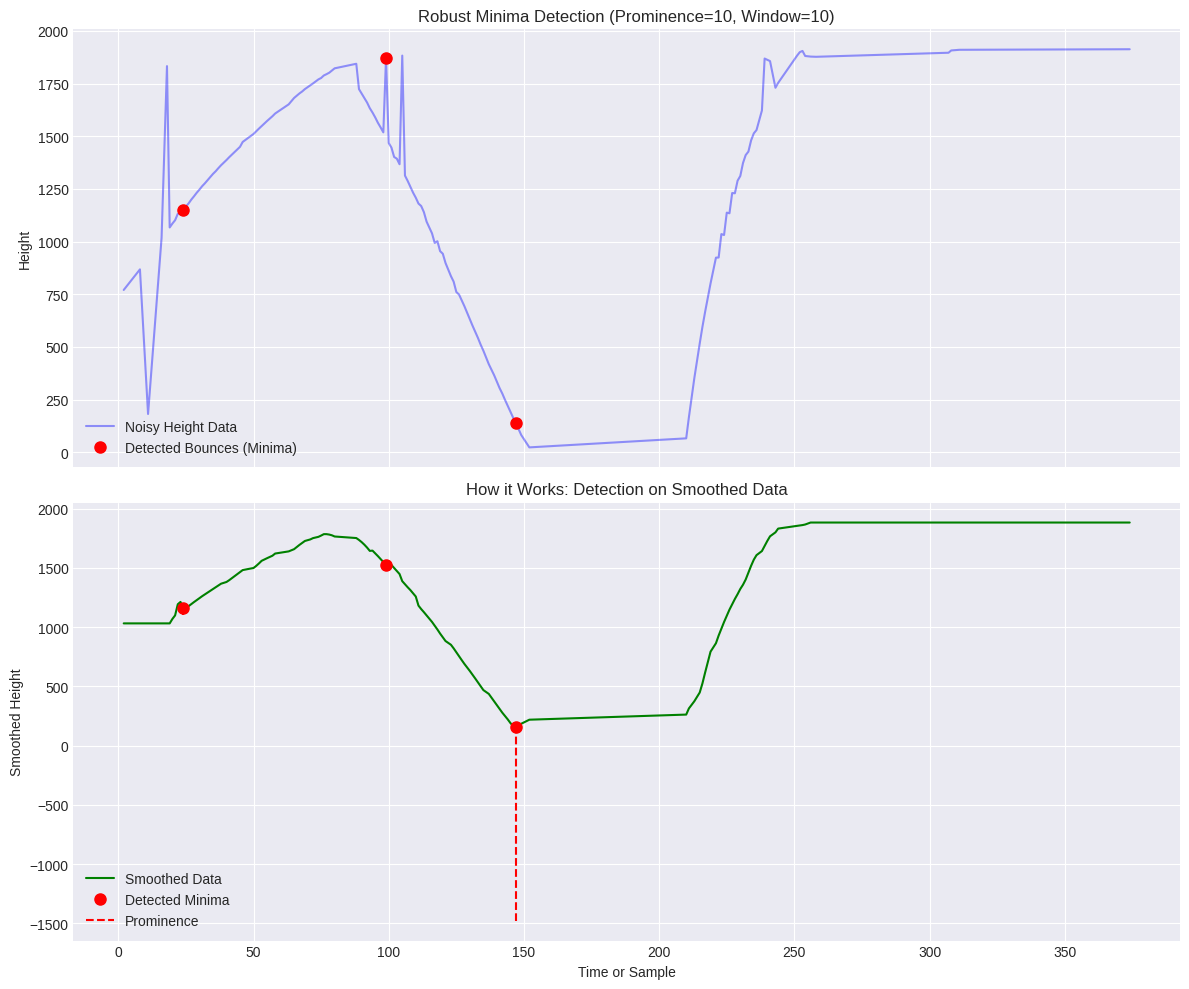

In [ ]:
# --- Example Usage ---
if __name__ == "__main__":
    # 1. Generate sample "bouncing ball" data
    
    # Create a time axis
    x = np.array(tracker.frame_numbers)
    
    # How much to smooth the data. Larger window = more smoothing.
    SMA_WINDOW = 10
    
    # How "deep" a bounce must be to count.
    # Should be > noise_level
    MIN_PROMINENCE = 10
    
    # Minimum points between bounces
    MIN_DISTANCE = 10 

    # 3. Run the detection
    y_positions = np.array([pos[0] for pos in tracker.recorded_positions2d])
    indices, smoothed, properties = find_robust_peaks(
        y_positions,
        smooth_window_size=SMA_WINDOW,
        prominence=MIN_PROMINENCE,
        distance=MIN_DISTANCE,
        peak_type='min'
    )
    
    print(f"Detected {len(indices)} robust minima at indices: {indices}")

    # 4. Plot the results
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # --- Plot 1: Raw Data and Detections ---
    ax1.set_title(f"Robust Minima Detection (Prominence={MIN_PROMINENCE}, Window={SMA_WINDOW})")
    ax1.plot(x, y_positions, label='Noisy Height Data', color='blue', alpha=0.4)
    
    # Plot detected minima on the *original* noisy data
    ax1.plot(x[indices], y_positions[indices], 'ro', markersize=8, 
             label='Detected Bounces (Minima)')
    ax1.set_ylabel("Height")
    ax1.legend()

    # --- Plot 2: Smoothed Data and Detections ---
    ax2.set_title("How it Works: Detection on Smoothed Data")
    ax2.plot(x, smoothed, label='Smoothed Data', color='green')
    
    # Plot detected minima on the *smoothed* data
    ax2.plot(x[indices], smoothed[indices], 'ro', markersize=8, 
             label='Detected Minima')
             
    # Plot prominence "shoulders" for visualization
    if 'prominences' in locals().get('properties', {}):
        prominences = properties["prominences"]
        contour_heights = smoothed[indices] - prominences
        ax2.vlines(x=x[indices], ymin=contour_heights, ymax=smoothed[indices], 
                   color='red', linestyle='--', label='Prominence')

    ax2.set_xlabel("Time or Sample")
    ax2.set_ylabel("Smoothed Height")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

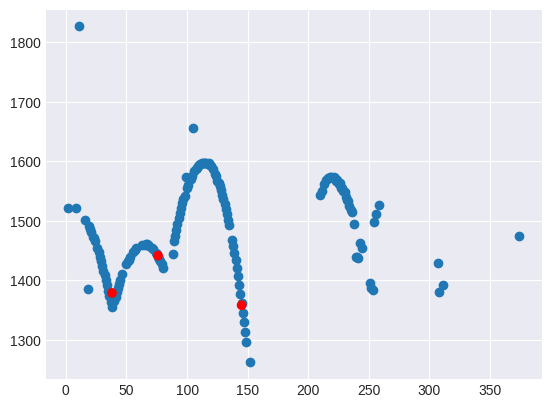

In [ ]:
plt.scatter(x, y_positions)
plt.scatter(x[indices], smoothed[indices], c=[[1, 0, 0] for _ in range(len(indices))])

In [ ]:
x_positions = np.array([pos[0] for pos in tracker.recorded_positions2d])
x_positions = median_filter(x_positions, size=6)
indices, smoothed, properties = find_robust_peaks(
        x_positions,
        smooth_window_size=7,
        prominence=30,
        distance=10,
        peak_type='both'
    )
print(indices)

{'minima': array([112]), 'maxima': array([51])}


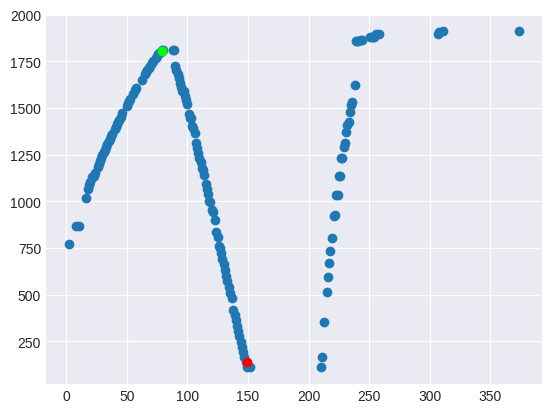

In [ ]:
plt.scatter(x, x_positions)
plt.scatter(x[indices['minima']], smoothed[indices['minima']], c=[[1, 0, 0] for _ in range(len(indices['minima']))])
plt.scatter(x[indices['maxima']], smoothed[indices['maxima']], c=[[0, 1, 0] for _ in range(len(indices['maxima']))])